# Milestone 3 Visualizations

In [1]:
import sys
sys.path.append("../../code")
import altair_data_transformer
import preprocess_change_col_type
from shapely.geometry import Point

import altair as alt
import pre_commit as pc
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import zipfile
import os
import warnings

In [2]:
data_dir = 'altairdata'
altair_data_transformer.setup_altair_for_large_data(data_dir)

In [3]:
# tree df
tree_df = pd.read_csv("../../data/processed/public_trees_cleaned_filled_neighbhour.csv")
tree_df = preprocess_change_col_type.convert_column_types(tree_df)

# geojson with the boundaries
geo_data_raw = gpd.read_file("../../data/processed/local_area_boundary.geojson")
geo_data_raw['NEIGHBOURHOOD_NAME'] = geo_data_raw['name'].str.upper()
geo_data = gpd.GeoDataFrame(geo_data_raw)

## Visualization 1
#### Which neighbourhoods have the highest density of large trees (e.g., height over 40 feet) that provide ample shade for comfortable picnic spots? Large trees are essential for creating shaded areas, which can significantly enhance the picnic experience on sunny days.

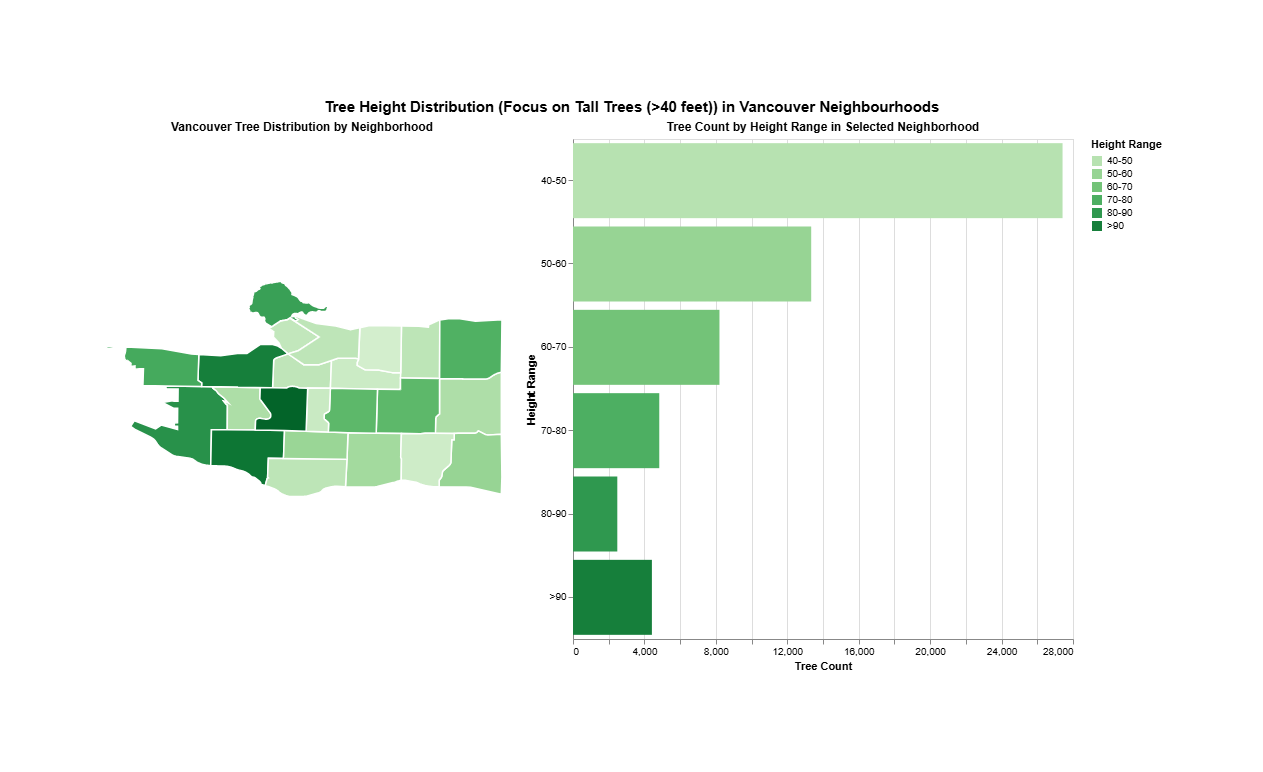

In [4]:
# make the dataset smaller -- else 131MB --> now down to 15MB

tree_df_small = tree_df[['NEIGHBOURHOOD_NAME', 'HEIGHT_RANGE']].copy()

tree_df_small['HEIGHT'] = tree_df_small['HEIGHT_RANGE'].apply(
    lambda x: 90 if x == '>90' else (40 if x == '40-50' else (int(x.split('-')[0]) + int(x.split('-')[1])) / 2)
)

tall_trees_df = tree_df_small[tree_df_small['HEIGHT'] > 40]

tall_trees_in_neigh = (
    tall_trees_df.groupby('NEIGHBOURHOOD_NAME')
    .size()
    .reset_index(name='TALL_TREES_COUNT')
    .sort_values(by='TALL_TREES_COUNT', ascending=False)
    .reset_index(drop=True)
)
tall_trees_in_neigh['TALL_RANK'] = tall_trees_in_neigh.index + 1

total_num_trees_in_neigh = (
    tree_df_small.groupby('NEIGHBOURHOOD_NAME')
    .size()
    .reset_index(name='TOTAL_TREES')
)

# Merge datasets
neighborhood_data = pd.merge(
    total_num_trees_in_neigh,
    tall_trees_in_neigh,
    on='NEIGHBOURHOOD_NAME',
    how='left'
).fillna(0)

# ------------------------------------------------------------
height_slider = alt.binding_range(
    min=40,
    max=90,
    step=5,
    name="At Least Height:"
)
height_selection = alt.selection_point(
    bind=height_slider,
    fields=['HEIGHT'],
    value=40
)

# ------------------------------------------------------------
neighborhood_click = alt.selection_point(
    name="neighborhood_click",
    fields=['NEIGHBOURHOOD_NAME'],
    bind=alt.binding_select(
        options=tree_df_small['NEIGHBOURHOOD_NAME'].unique().tolist(),
        name="Select Neighborhood:"
    )
)

# =========================
# Tree Map for Neighborhoods
# =========================
f1_tree_map = (
    alt.Chart(geo_data)
    .mark_geoshape(stroke='white', strokeWidth=1.5)
    .transform_lookup(
        lookup="NEIGHBOURHOOD_NAME",
        from_=alt.LookupData(neighborhood_data, 'NEIGHBOURHOOD_NAME', 
                             ['NEIGHBOURHOOD_NAME', 'TOTAL_TREES', 'TALL_TREES_COUNT', 'TALL_RANK'])
    )
    .encode(
        color=alt.Color("TALL_TREES_COUNT:Q", title="Total Trees (>40ft)", scale=alt.Scale(scheme='greens'), legend=None),
        opacity=alt.condition(neighborhood_click, alt.value(1), alt.value(0.15)),
        tooltip=[
            alt.Tooltip("NEIGHBOURHOOD_NAME:N", title="Neighborhood"),
            alt.Tooltip("TOTAL_TREES:Q", title="Total Trees"),
            alt.Tooltip("TALL_TREES_COUNT:Q", title="Tall Trees (>40ft)"),
            alt.Tooltip("TALL_RANK:Q", title="Rank by Tall Trees")
        ]
    )
    .properties(width=400, height=500, title=alt.TitleParams(
        "Vancouver Tree Distribution by Neighborhood",
        fontSize=12, 
        anchor='middle'))
    .project(type='identity', reflectY=True)
    .add_params(neighborhood_click)
)

# =========================
# Bar Chart: Tree Count by Height Range and Neighborhood
# =========================
f1_bar_chart = (
    alt.Chart(tree_df_small)
    .mark_bar()
    .transform_filter(neighborhood_click)
    .encode(
        y=alt.Y('HEIGHT_RANGE:N', title='Height Range'),
        x=alt.X('count():Q', title='Tree Count'),
        color=alt.Color('HEIGHT_RANGE:N', scale=alt.Scale(scheme='greens'), title="Height Range"),
        tooltip=['HEIGHT_RANGE:N', 'count():Q']
    )
    .properties(width=500, height=500, title=alt.TitleParams(
        "Tree Count by Height Range in Selected Neighborhood",
        fontSize=12, 
        anchor='middle'))
    .add_params(height_selection)
    .transform_filter(f"datum.HEIGHT >= {height_selection.name}.HEIGHT")
)

# ------------------------------------------------------------
final_f1 = (f1_tree_map | f1_bar_chart).properties(
    title="Tree Height Distribution (Focus on Tall Trees (>40 feet)) in Vancouver Neighbourhoods",
    padding=100
).configure_title(fontSize=15, offset=5, orient='top', anchor='middle')

final_f1

In [5]:
html_file = "../../images/kli_viz/picnic_viz1.html"

final_f1.save(html_file)

### Viz 1 Summary - Hitting the Criteria

#### Justification of Visualization Choices

#### Marks
- Map (Geospatial Visualization):  
  - Used to display tall tree counts (>40ft) across Vancouver neighborhoods.  
  - The geospatial layout provides geographic context, helping users quickly identify areas with dense tall trees.  
  - Color intensity (greens scheme) encodes tall tree counts, emphasizing neighborhoods with the highest concentrations of mature vegetation.  

- Bar Chart:  
  - Used to show the distribution of trees by height range within the selected neighborhood.  
  - Bar lengths represent tree counts for each height range, enabling detailed analysis of tree height composition and supporting comparisons.  

#### Channels
- Map  
  - Position: Geographic boundaries represent neighborhoods, offering spatial context for tall tree distributions.  
  - Color: Encodes tall tree counts using a gradient (greens scheme), making it easy to spot areas with high tall tree densities.  
  - Opacity: Highlights the selected neighborhood in full opacity while dimming others, focusing user attention on the chosen area.  
  - Tooltip: Provides additional details like total tree count, tall tree count, and rank, enhancing interpretability.  

- Bar Chart  
  - Position:  
    - Y-axis represents height ranges, organizing data into discrete categories.  
    - X-axis indicates tree count, showing magnitude.  
  - Length: Bar lengths encode the number of trees in each height range, simplifying comparisons.  
  - Color: Uses a consistent greens scheme to align with the map, reinforcing the focus on tall trees.  
  - Tooltip: Displays exact values for tree counts and height ranges, improving clarity.  


#### Interaction and UI Widgets
- Height Slider:  
  - Filters trees based on a minimum height threshold (e.g., "At Least Height: 50ft").  
  - This ensures the visualization focuses on tall trees, aligning with the goal of identifying mature vegetation suitable for picnic environments.  

- Neighborhood Dropdown:  
  - Allows users to select a specific neighborhood, dynamically updating both the map and bar chart.  
  - This interaction enables focused analysis by neighborhood, ensuring the visualization adapts to the user’s chosen area.  

- Linked Filtering:  
  - Synchronizes the map and bar chart. Selecting a neighborhood updates both visualizations, creating a cohesive exploration experience.  

- Conditional Highlighting:  
  - Highlights the selected neighborhood in full opacity while dimming others, improving focus and reducing visual clutter.  

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values for tall tree counts, height ranges, and ranks, enhancing interpretability without cluttering the visualization.  

#### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as tall tree counts, neighborhood names, and height range distributions.  
- Filter: Users can filter data by neighborhood (via dropdown) and by tree height (via slider), enabling focused exploration.  
- Compute Derived Value: Aggregated metrics like total tree count and tall tree count per neighborhood are computed and displayed, providing insights into tree density and maturity.  
- Find Extremum: The map highlights neighborhoods with the highest tall tree densities, while the bar chart identifies dominant height ranges.  
- Sort: Neighborhoods are implicitly ranked by tall tree counts (via color intensity on the map), and height ranges are sorted by tree count in the bar chart.  
- Determine Range: The map’s color scale visualizes the span of tall tree counts across neighborhoods, helping users understand variability.  
- Characterize Distribution: The combination of the map and bar chart allows users to analyze the spread of tall trees spatially and compositionally.  

#### Why These Choices Were Effective
1. Comprehensive Analysis:  
   - The map provides an overview of spatial patterns, highlighting areas with dense tall trees.  
   - The bar chart complements the map by offering detailed insights into tree height composition at the neighborhood level.  
   - Together, they provide a holistic view of Vancouver's tree ecosystem, addressing both spatial and compositional aspects.  

2. Dynamic Exploration:  
   - The dropdown menu and height slider allow users to explore the data dynamically, refining their analysis based on neighborhood and tree size.  
   - Linked filtering ensures consistency between the map and bar chart, maintaining a seamless exploration experience.  

3. Enhanced Interpretability:  
   - Conditional highlighting and tooltips improve clarity, making it easier for users to interpret the data and make informed decisions about identifying neighborhoods with the highest density of large trees for comfortable picnic spots.  

## Visualization 2
#### Which neighbourhoods have the highest diversity of tree families, offering visually varied and unique picnic environments? A mix of tree species can create a more aesthetically pleasing and engaging atmosphere for picnickers.

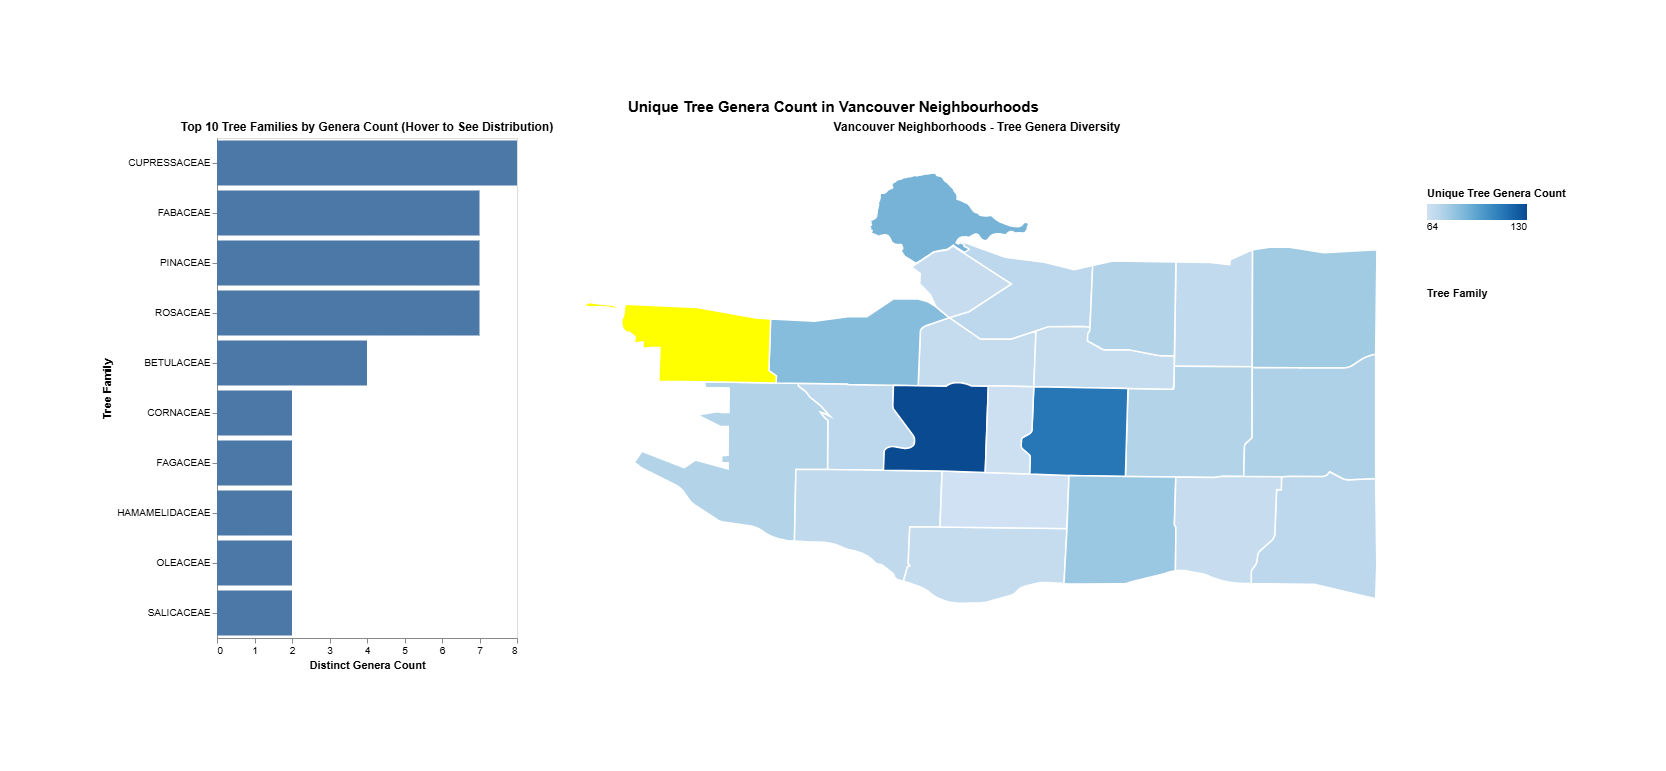

In [7]:
# =========================================================================
# Data Preparation

# Aggregate unique genera count per neighborhood and top families
unique_genera_by_neighborhood = tree_df.groupby('NEIGHBOURHOOD_NAME', observed=False)['GENUS_NAME'].nunique().reset_index(name="TOTAL_GENUS_COUNT")
aggregated_data = tree_df.groupby(['FAMILY_NAME', 'NEIGHBOURHOOD_NAME'], observed=False)['GENUS_NAME'].nunique().reset_index()
top_families = aggregated_data.groupby('FAMILY_NAME', observed=False)['GENUS_NAME'].sum().nlargest(10).reset_index()

merged_data = geo_data.merge(unique_genera_by_neighborhood, left_on='NEIGHBOURHOOD_NAME', right_on='NEIGHBOURHOOD_NAME', how='outer').fillna({'TOTAL_GENUS_COUNT': 0}) 
merged_data['rank'] = merged_data['TOTAL_GENUS_COUNT'].rank(ascending=False, method='min')

f2_df_points = tree_df[['NEIGHBOURHOOD_NAME', 'FAMILY_NAME', 'LONGITUDE', 'LATITUDE']]

filtered_data = aggregated_data[aggregated_data['FAMILY_NAME'].isin(top_families['FAMILY_NAME'])]
# =========================================================================
# Interaction Setup
# =========================================================================

neighborhood_selection = alt.selection_point(fields=['NEIGHBOURHOOD_NAME'], empty=False, value="WEST POINT GREY")

hover_selection = alt.selection_point(
    on='mouseover', 
    fields=['FAMILY_NAME'], 
    empty=False, 
    clear='mouseout'  
)


# --------------------------------------------

f2_points = (
    alt.Chart(f2_df_points)
    .mark_circle()
    .transform_filter(hover_selection)
    .transform_filter(neighborhood_selection)  # Apply filters separately
    .add_params(hover_selection)
    .encode(
        longitude=alt.X('LONGITUDE:Q', title="Longitude"),
        latitude=alt.Y('LATITUDE:Q', title="Latitude"),
        size=alt.value(1),
        opacity=alt.condition(hover_selection, alt.value(1), alt.value(0)),  
        color=alt.Color(
            'FAMILY_NAME:N',
            scale=alt.Scale(scheme='category20'),
            legend=alt.Legend(
                title="Tree Family",
                orient='none',  
                legendX=850, 
                legendY=150, 
                columns=1,
                symbolType='circle',
                symbolSize=100
            )
        )
    )
    .properties(
        width=800,
        height=500,
    )
)




f2_bar_chart = (
    alt.Chart(filtered_data)
    .transform_filter(neighborhood_selection)
    .mark_bar()
    .encode(
        y=alt.Y("FAMILY_NAME:N", title="Tree Family", sort='-x'),
        x=alt.X("GENUS_NAME:Q", title="Distinct Genera Count"),
        tooltip=[
            alt.Tooltip("FAMILY_NAME:N", title="Tree Family"),
            alt.Tooltip("GENUS_NAME:Q", title="Distinct Genera Count")
        ]
    )
    .properties(
        width=300,
        height=500,
        title=alt.TitleParams(
            "Top 10 Tree Families by Genera Count (Hover to See Distribution)",
            fontSize=12, 
            anchor='middle'
        )
    )
    .add_params(neighborhood_selection, hover_selection)
)

# ---------------------------

f2_tree_map = (
    alt.Chart(merged_data)
    .mark_geoshape(stroke='white', strokeWidth=1.5)
    .transform_lookup(
        lookup="NEIGHBOURHOOD_NAME",
        from_=alt.LookupData(
            unique_genera_by_neighborhood,
            'NEIGHBOURHOOD_NAME',
            ['NEIGHBOURHOOD_NAME', 'TOTAL_GENUS_COUNT']
        )
    )
    .encode(
color=alt.condition(
    neighborhood_selection,
    alt.value('yellow'),
    alt.Color(
        "TOTAL_GENUS_COUNT:Q",
        title="Unique Tree Genera Count",
        scale=alt.Scale(scheme='blues'),
        legend=alt.Legend(
            orient='none',
            legendX=850,   # Adjust X position
            legendY=50,    # Top position for color scale legend
            direction='horizontal'
                ))),
        tooltip=[
            alt.Tooltip("NEIGHBOURHOOD_NAME:N", title="Vancouver Neighbourhood"),
            alt.Tooltip("TOTAL_GENUS_COUNT:Q", title="Unique Tree Genera Count"),
            alt.Tooltip("rank:Q", title="Rank by # of Unique Trees")
        ]
    )
    .properties(
        width=800,
        height=500,
        title=alt.TitleParams(
            "Vancouver Neighborhoods - Tree Genera Diversity",
            fontSize=12,
            anchor='middle' 
        )
    )
    .project(type='identity', reflectY=True) 
    .add_params(neighborhood_selection)
)

# =========================================================================
# Combined Visualization
# =========================================================================

final_f2 = (
    (f2_bar_chart | f2_tree_map + f2_points)  
    .properties(
        title=alt.TitleParams(
            "Unique Tree Genera Count in Vancouver Neighbourhoods",
            fontSize=15,
            offset=5,
            orient='top',
            anchor='middle'
        ),
        padding=100
    )
    .configure_title(fontSize=10)
).configure_axis(grid=False)

final_f2

In [8]:
html_file = "../../images/kli_viz/picnic_viz2.html"

final_f2.save(html_file)

### Viz 2 Summary - Hitting the Criteria

#### Justification of Visualization Choices

#### Marks
- Map (Geospatial Visualization):  
  - Used to display the diversity of tree genera across Vancouver neighborhoods.  
  - The geospatial layout provides geographic context, enabling users to quickly identify areas with high biodiversity.  
  - Color intensity (`blues` scheme) encodes unique tree genera counts, making it easy to spot neighborhoods with the highest ecological richness.

- Scatterplot:  
  - Visualizes the distribution of individual trees across Vancouver neighborhoods, offering a detailed view of their spatial arrangement.  
  - Each point represents a tree, plotted based on its geographic coordinates, allowing users to easily identify where specific tree species are located.  
  - The scatterplot helps to identify areas of higher tree density and potential clusters, providing further insights into the local distribution of tree genera.  
  - By pairing the scatterplot with the geospatial map, users can compare the spatial distribution of trees with the biodiversity data, offering a richer understanding of the ecological landscape.


- Bar Chart:  
  - Used to show the top 10 tree families by distinct genera count for the selected neighborhood.  
  - Bar lengths represent the number of distinct genera per family, enabling comparisons and highlighting the most biodiverse families.  

#### Channels
- Map  
  - Position: Geographic boundaries represent neighborhoods, offering spatial context for biodiversity distribution.  
  - Color: Encodes unique tree genera counts using a gradient (`blues` scheme), emphasizing areas with high biodiversity.  
  - Highlighting: Highlights the selected neighborhood in yellow, drawing attention to the area under analysis.  
  - Tooltip: Provides additional details like neighborhood name, unique genera count, and rank, enhancing interpretability.  

- Bar Chart  
  - Position:  
    - Y-axis lists tree families, sorted in descending order of distinct genera count, emphasizing the most biodiverse families.  
    - X-axis represents the number of distinct genera, showing magnitude.  
  - Length: Bar lengths encode the number of distinct genera, simplifying comparisons between families.  
  - Tooltip: Displays exact values for genera counts and family names, improving clarity.

- Scatterplot
  - Position: Points represent individual trees, plotted based on their geographic coordinates, offering insights into the spatial distribution of tree species.  
  - Opacity + Color: Points remain semi-transparent by default and become fully visible when hovered over, with color indicating the tree's genus or family.  

#### Interaction and UI Widgets

- Bi-directional Interaction:
    - Mouse-Based Neighborhood Selection: 
      - Users can click on a neighborhood on the map to filter the bar chart, displaying data specific to that neighborhood. This allows users to explore how tree families vary across neighborhoods.
    - Hover-Based Family Name Selection:
      - Users can hover over a family name in the bar chart to see its distribution across neighborhoods on the map. This interaction enables users to visualize how the presence of a specific tree family is spread geographically.
    - These interactions are bi-directional because the actions in one visualization (either the map or the bar chart) update the other, creating a synchronized, dynamic exploration experience.

- Conditional Highlighting:  
  - Highlights the selected neighborhood in yellow while dimming others, improving focus and reducing cognitive load.  

- Linked Filtering:  
  - Ensures the map and bar chart remain synchronized. Clicking on a neighborhood updates both visualizations, creating a cohesive exploration experience.  

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values for unique genera counts, ranks, and family-specific details, enhancing interpretability without cluttering the visualization.  


### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as unique genera counts, neighborhood names, and biodiversity ranks.  
- Filter: Users can filter data by neighborhood (via mouse-based selection), enabling focused exploration.  
- Find Extremum: The map highlights neighborhoods with the highest biodiversity, while the bar chart identifies the most biodiverse tree families.  
- Sort: Neighborhoods are implicitly ranked by biodiversity (via color intensity on the map), and tree families are explicitly sorted by genera count in the bar chart.  
- Characterize Distribution: The combination of the map and bar chart allows users to analyze the spread of biodiversity spatially and compositionally.  


### Why These Choices Were Effective
1. Data Processing:  
   - Aggregating unique genera counts per neighborhood and identifying the top 10 tree families ensures the visualization is concise and focused on significant contributors to biodiversity.  
   - Filtering the dataset avoids overwhelming users with less relevant data while still providing meaningful insights into biodiversity patterns.  

2. Comprehensive Analysis:  
   - The map provides an overview of spatial patterns, highlighting areas with high or low biodiversity.  
   - The bar chart complements the map by offering detailed insights into the composition of biodiversity, breaking down data by tree families.  
   - Together, they provide a holistic view of Vancouver’s urban tree ecosystem, balancing broad overviews with granular analyses.  

3. Dynamic Exploration:  
   - Mouse-based neighborhood selection and linked filtering enable seamless exploration, allowing users to transition from spatial patterns to family-level breakdowns.  
   - Conditional highlighting improves focus, reducing cognitive load and enhancing interpretability.  

4. Enhanced Interpretability:  
   - Tooltips and conditional highlighting make the visualization accessible to a wide audience, supporting informed decision-making about neighborhoods with diverse picnic environments.  


## Visualization 3
#### Which neighbourhoods have trees that produce high amounts of pollen, potentially affecting picnic experiences for people with allergies? Identifying high-pollen areas can help allergy sufferers avoid discomfort or plan allergy-friendly events.

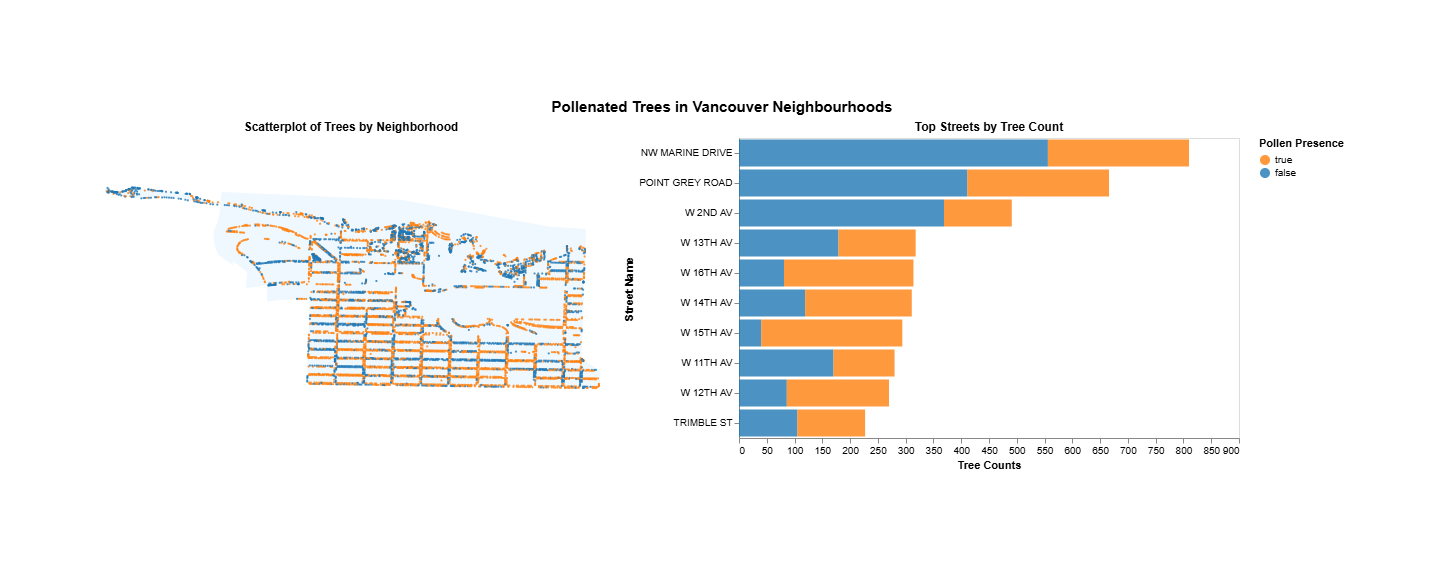

In [9]:
warnings.simplefilter("ignore", category=DeprecationWarning)

# =======================================
# data prep

tree_df_points = tree_df[['NEIGHBOURHOOD_NAME', 'HAS_POLLEN', 'LONGITUDE', 'LATITUDE', 'ON_STREET']]

tree_on_street_df = tree_df.groupby(['ON_STREET', 'NEIGHBOURHOOD_NAME'], observed=False).size().reset_index(name='COUNT')

top_10_streets_per_neighborhood = (
    tree_on_street_df.groupby('NEIGHBOURHOOD_NAME', observed=False)
    .apply(lambda group: group.sort_values(by='COUNT', ascending=False).head(10))  
    .reset_index(drop=True)  
)

filtered_tree_on_street_df = pd.merge(
    tree_on_street_df, 
    top_10_streets_per_neighborhood[['NEIGHBOURHOOD_NAME', 'ON_STREET']], 
    on=['NEIGHBOURHOOD_NAME', 'ON_STREET'], 
    how='inner' 
)


tree_on_street_df_main = (
    tree_df.groupby(['ON_STREET', 'HAS_POLLEN', 'NEIGHBOURHOOD_NAME'], observed=False)
    .size()  
    .reset_index(name='COUNT')  
)

filtered_tree_on_street_df = pd.merge(tree_on_street_df_main, 
    top_10_streets_per_neighborhood[['NEIGHBOURHOOD_NAME', 'ON_STREET']], 
    on=['NEIGHBOURHOOD_NAME', 'ON_STREET'], 
    how='inner')

# =======================================

# Selections
neighborhood_selection = alt.selection_point(
    fields=['NEIGHBOURHOOD_NAME'], 
    bind=alt.binding_select(options=tree_df['NEIGHBOURHOOD_NAME'].unique().tolist(), name="Select Neighborhood:"),
    name="neighborhood_selection",
    empty=True,
    value="WEST POINT GREY"
)

# pollen
pollen_selection = alt.selection_point(
    fields=['HAS_POLLEN'], 
    bind=alt.binding_radio(
        options=[True, False, None],
        labels=["Yes", "No", "All"],  
        name="Has Pollen:"
    ),
    name="pollen_selection",
    empty=True 
)


# search
search_box = alt.param(
    value='',
    bind=alt.binding(input='text', placeholder="Street Name", name='Search ')
)

search_matches = alt.expr.test(alt.expr.regexp(search_box, "i"), alt.datum.ON_STREET)

opacity = alt.condition(
    search_matches,
    alt.value(0.8),
    alt.value(0.1)
)


# =====================================================
# Scatterplot
background = (
    alt.Chart(geo_data)
    .mark_geoshape(
        fill='#F0F8FF',
        stroke='white'
    )
    .transform_filter(neighborhood_selection)
    .project(
        type='identity', 
        reflectY=True    
    )
    .properties(
        width=500,
        height=300,
        title=alt.TitleParams(
            "Scatterplot of Trees by Neighborhood",
            fontSize=12, 
            anchor='middle'
        )
    )
    .add_params(neighborhood_selection, pollen_selection)
)

f3_points = (
    alt.Chart(tree_df_points)
    .transform_filter(neighborhood_selection)
    .transform_filter(pollen_selection)
    .mark_circle()
    .encode(
        longitude=alt.X('LONGITUDE:Q', title="Longitude"),
        latitude=alt.Y('LATITUDE:Q', title="Latitude"),
        size=alt.value(4),
        color=alt.Color(
            'HAS_POLLEN:N',
            legend=alt.Legend(title="Pollen Presence"),
            scale=alt.Scale(domain=[True, False], range=['#ff7f0e', '#1f77b4'])
        ),
        tooltip=['ON_STREET:N'],
        opacity=opacity
    )
    .add_params(neighborhood_selection, pollen_selection, search_box) 
    .properties(
        width=500,
        height=300
    )
)

# =====================================================
# Bar chart (top 10 streets by neighborhood)

f3_bar = (
    alt.Chart(filtered_tree_on_street_df)
    .transform_filter(neighborhood_selection)
    .transform_filter(pollen_selection)
    .mark_bar()
    .encode(
        y=alt.Y("ON_STREET:N", title="Street Name", sort='-x'),  
        x=alt.X("COUNT:Q", title="Tree Counts"),               
        color=alt.Color(
            "HAS_POLLEN:N",
            legend=alt.Legend(title="Pollen Presence"),       
            scale=alt.Scale(domain=[True, False], range=['#ff7f0e', '#1f77b4'])
        ),
        opacity=alt.OpacityValue(0.8),
        tooltip=[
            alt.Tooltip("ON_STREET:N", title="Street Name"),
            alt.Tooltip("COUNT:Q", title="Number of Trees"),
            alt.Tooltip("HAS_POLLEN:N", title="Has Pollen")
        ]
    )
    .add_params(neighborhood_selection, pollen_selection)
    .properties(
        width=500,
        height=300,
        title=alt.TitleParams(
            "Top Streets by Tree Count",
            fontSize=12, 
            anchor='middle'
        )
    )
)

final_f3 = (
    (background + f3_points) | f3_bar
).properties(
    title=alt.TitleParams(
            "Pollenated Trees in Vancouver Neighbourhoods",
            fontSize=15,
            offset=5,
            orient='top',
            anchor='middle'
        ), padding=100
).configure_title(fontSize=10
).configure_axis(grid=False)

final_f3

In [10]:
html_file = "../../images/kli_viz/picnic_viz3.html"

final_f3.save(html_file)

## Viz 3 Summary - Hitting the Criteria

### Justification of Visualization Choices

#### Marks
- Scatterplot:  
  - Used to display the spatial distribution of trees in the selected neighborhood, with points color-coded by pollen presence (Yes/No).  
  - The scatterplot provides a geographic overview, enabling users to identify areas with high concentrations of pollen-producing trees or non-pollen-producing trees.  

- Bar Chart:  
  - Used to show the top 10 streets by tree count in the selected neighborhood, further broken down by pollen presence.  
  - Bar lengths represent tree counts, and color differentiation highlights the proportion of pollen-producing vs. non-pollen-producing trees on each street.  

#### Channels
- Scatterplot  
  - Position: X and Y coordinates represent the geographic locations of trees, offering spatial context.  
  - Color: Encodes pollen presence using distinct colors (e.g., red for "Yes" and blue for "No"), making it easy to distinguish between pollen-producing and non-pollen-producing trees.  
  - Tooltip: Provides additional details like tree location and pollen status, enhancing interpretability.  

- Bar Chart  
  - Position:  
    - Y-axis lists streets, sorted by tree count in descending order, emphasizing streets with the highest tree densities.  
    - X-axis represents tree count, showing magnitude.  
  - Length: Bar lengths encode the number of trees, simplifying comparisons between streets.  
  - Color: Differentiates between pollen-producing and non-pollen-producing trees within each street, highlighting compositional patterns.  
  - Tooltip: Displays exact values for tree counts and pollen breakdowns, improving clarity.  


#### Interaction and UI Widgets
- Dropdown Menu (Neighborhood Selection):  
  - Allows users to select a specific neighborhood from a list, dynamically updating both the scatterplot and bar chart.  
  - This interaction ensures the visualization adapts to the user’s chosen area, enabling focused exploration.  

- Pollen Radio Button (Has Pollen Selection):  
  - Lets users filter trees based on whether they produce pollen ("Yes" or "No").  
  - This feature allows users to focus on specific subsets of data, such as identifying high-pollen areas or planning allergy-friendly events.

- Search box (Street Name Selection):
    - Enables users to search for trees located on a specific street.
    - This feature helps users find tree distributions along particular roads, allowing for detailed location-based exploration.

- Linked Filtering:  
  - Ensures both the scatterplot and bar chart update dynamically based on the selections.  
  - For example, selecting a neighborhood updates both visualizations, while filtering by pollen presence refines the displayed data consistently across views.  

- Tooltip Enhancements:  
  - Tooltips provide precise numerical values and additional context, such as tree location and pollen status, without cluttering the visualization.  


### Tasks Supported by the Visualization
- Retrieve Value: Tooltips allow users to extract specific details, such as tree locations and pollen statuses.  
- Filter: Users can filter data by neighborhood (via dropdown) and pollen presence (via radio buttons), enabling focused exploration.  
- Find Extremum: The scatterplot highlights areas with high concentrations of pollen-producing trees, while the bar chart identifies streets with the most trees.  
- Sort: Streets are explicitly sorted by tree count in the bar chart, emphasizing areas with the highest tree densities.  
- Characterize Distribution: The combination of the scatterplot and bar chart allows users to analyze the spread of pollen-producing trees spatially and compositionally.  


### Why These Choices Were Effective
1. Comprehensive Analysis:  
   - The scatterplot provides a spatial overview of tree distribution, helping users identify areas with high pollen-producing tree concentrations.  
   - The bar chart complements the scatterplot by offering detailed insights into specific streets, breaking down data by pollen presence.  
   - Together, these visualizations provide a holistic view of Vancouver’s urban tree ecosystem, balancing broad overviews with granular analyses.  

2. Dynamic Exploration:  
   - Dropdown and radio button selections give users control over filtering data, enabling them to explore patterns of pollen presence in specific neighborhoods.  
   - Linked filtering ensures consistency across visualizations, reducing confusion and maintaining focus.  

3. Enhanced Interpretability:  
   - Tooltips and clear color encoding improve clarity, making the visualization accessible to a wide audience.  
   - These features support informed decision-making about identifying high-pollen areas to avoid discomfort for allergy sufferers or plan allergy-friendly events.  
